# Time Series Analysis on National Stock Exchange

### Importing Libs

In [1]:
import numpy as np
import pandas as pd
import gc
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import time

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential, Input, initializers, optimizers, callbacks, layers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.model_selection import train_test_split
from keras.layers import SimpleRNN
from keras.layers import GRU
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, BatchNormalization, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D

### Getting the dataset

In [2]:
df = pd.read_csv('infy_stock.csv', usecols=['Date', 'Close'], parse_dates=['Date'], index_col='Date')

In [3]:
df.head()

,Close
Date,
2015-01-01,1974.40
2015-01-02,2013.20
2015-01-05,1995.90
2015-01-06,1954.20
2015-01-07,1963.55


In [4]:
print("Time Range:", df.index.max(), "to", df.index.min())

Time Range: 2015-12-31 00:00:00 to 2015-01-01 00:00:00


## What does the stock look like?

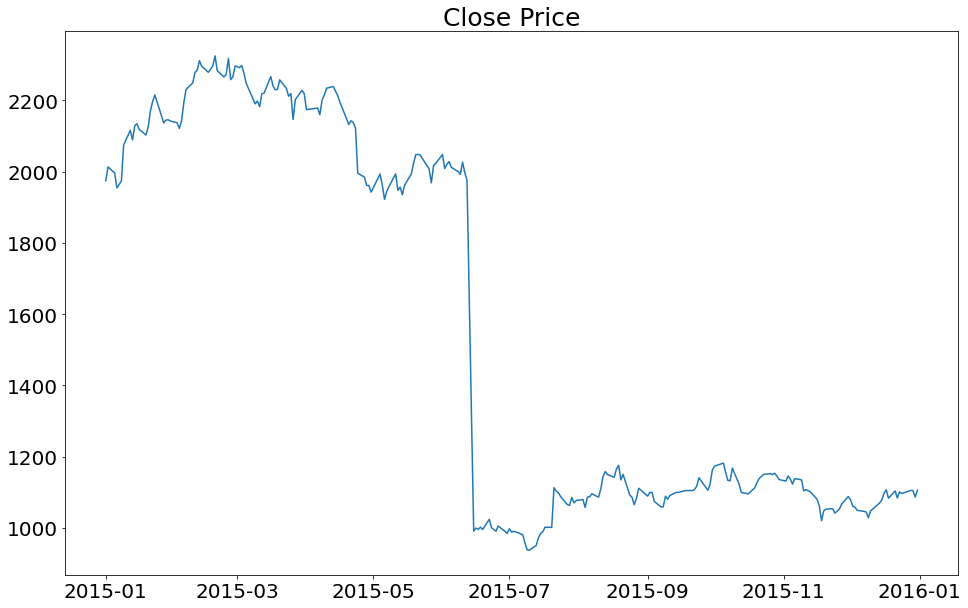

In [5]:
plt.figure(figsize=(16, 10))
plt.plot(df['Close'])
plt.title('Close Price', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

hmm, things went from a 2000 to 1000 real quick.

Jokes aside, this needs to be dealt with as this can cause the model not perform as expected. I expect normalizing the data should work in this case.

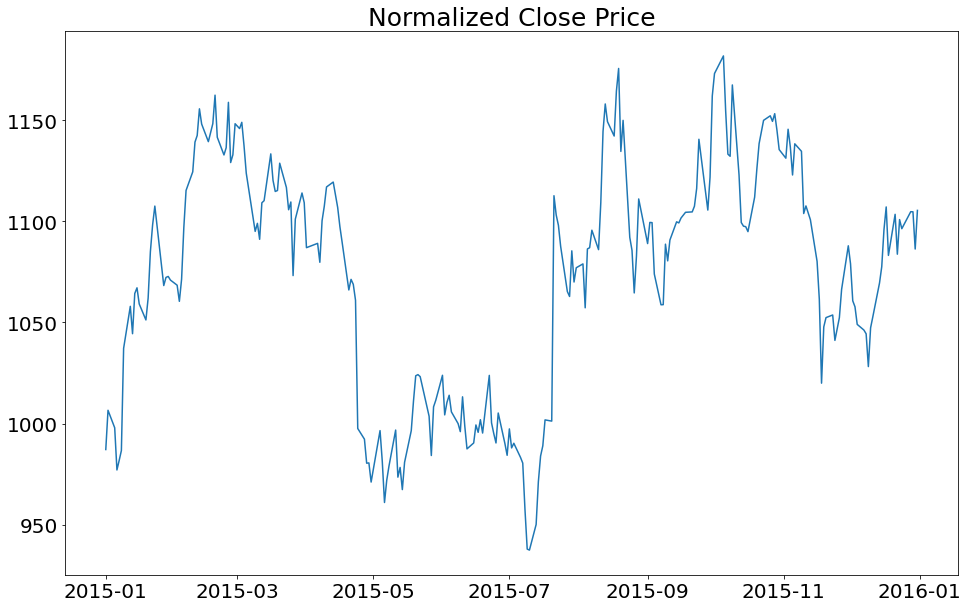

In [6]:
corrections = pd.concat([df.Close[:'2015-06-12']/2, df.Close['2015-06-15':]])
plt.figure(figsize=(16, 10))
plt.plot(corrections)
plt.title('Normalized Close Price', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

This looks more realistic than I anticipated

### Scaling and Spliting

In [7]:
scaler = StandardScaler()
prices = scaler.fit_transform(corrections.values.reshape(-1, 1)).flatten()
train, test = train_test_split(prices, test_size=0.3, shuffle=False)

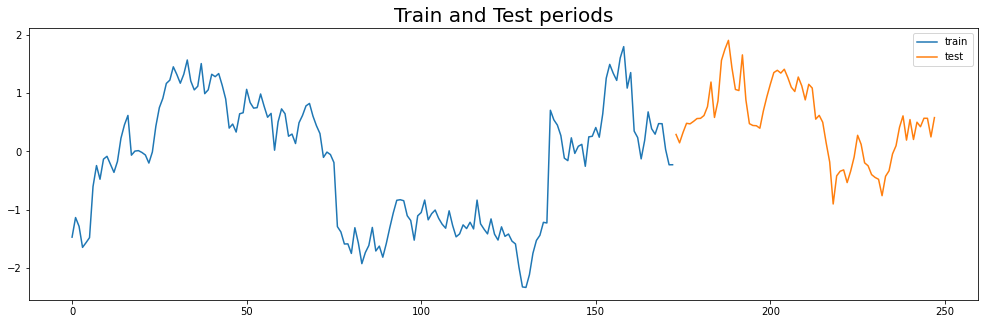

In [8]:
plt.figure(figsize=(17,5))
plt.plot(train, label='train')
plt.plot(np.arange(len(train), len(train)+len(test)), test, label='test')
plt.title("Train and Test periods", fontsize=20)
plt.legend()
plt.show()

### Breaking the sets into chunks

In [9]:
def chunk_it(sets, n_in, n_out):
    X, y = [], []
    start = 0
    for i in range(len(sets)):
        in_end = start + n_in
        out_end = in_end + n_out
        if out_end <= len(sets):
            x = sets[start:in_end]
            x = x.reshape((len(x), 1))
            X.append(x)
            y.append(train[in_end:out_end])
            start += 1
    return np.array(X), np.array(y)

In [10]:
n_input = 7
X_train, y_train = chunk_it(train, n_input, n_out=1)
X_test, y_test = chunk_it(test, n_input, n_out=1)

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [12]:
fit_params = {
        'x': X_train,
        'y': y_train,
        'validation_data': (X_test, y_test),
        'verbose': 1,
        'epochs': 50,
        'batch_size': 16}

In [13]:
def LossPlot(history):
    plt.figure(figsize=(17, 5))
    plt.plot(history.history['loss'], color='b', label='Train')
    plt.plot(history.history['val_loss'], color='r', label='Validation')
    plt.title('Loss Chart')
    plt.show()
    
def PredPlot(y_test, pred):
    plt.figure(figsize=(17, 5))
    plt.plot(pred, label='prediction')
    plt.plot(y_test, label='test')
    plt.legend()
    plt.title("Real and Predicted values")
    plt.show()

In [14]:
def mae(y_true, y_pred):
    output_errors = np.average(np.abs(y_pred - y_true), axis=0)
    return np.average(output_errors)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

def brief_stats(y_true, y_pred):
    print(pd.Series({
        'mape': mape(y_true, y_pred),
        'mae': mae(y_true, y_pred),
        'rmse': rmse(y_true, y_pred),
    }))

In [15]:
def basic_RNN():
    model = Sequential()
    model.add(SimpleRNN(1, input_shape=(1,n_input),
                   return_sequences=False
                  ))
    model.compile(loss='mse', optimizer='adam')
    return model

Epoch 1/50
11/11 [==============================] - 0s 23ms/step - loss: 3.5196 - val_loss: 1.9026
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 3.5140 - val_loss: 1.8973
Epoch 3/50
11/11 [==============================] - 0s 4ms/step - loss: 3.5077 - val_loss: 1.8916
Epoch 4/50
11/11 [==============================] - 0s 4ms/step - loss: 3.5017 - val_loss: 1.8854
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 3.4951 - val_loss: 1.8788
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 3.4872 - val_loss: 1.8720
Epoch 7/50
11/11 [==============================] - 0s 4ms/step - loss: 3.4795 - val_loss: 1.8646
Epoch 8/50
11/11 [==============================] - 0s 4ms/step - loss: 3.4709 - val_loss: 1.8563
Epoch 9/50
11/11 [==============================] - 0s 4ms/step - loss: 3.4618 - val_loss: 1.8469
Epoch 10/50
11/11 [==============================] - 0s 4ms/step - loss: 3.4517 - val_loss: 1.8367
Epoch 11/50
11/11 

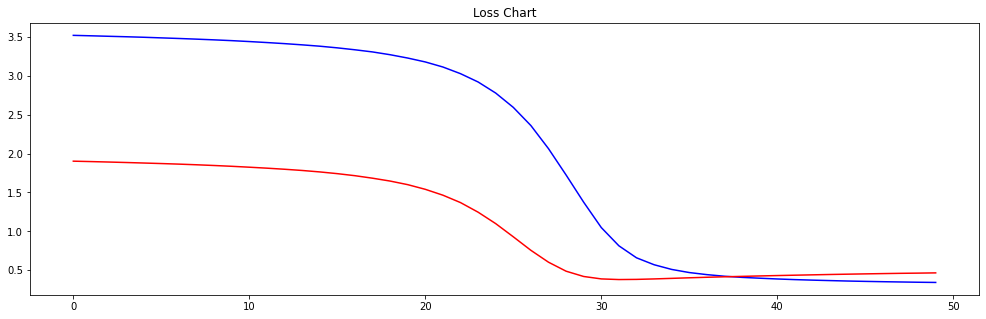

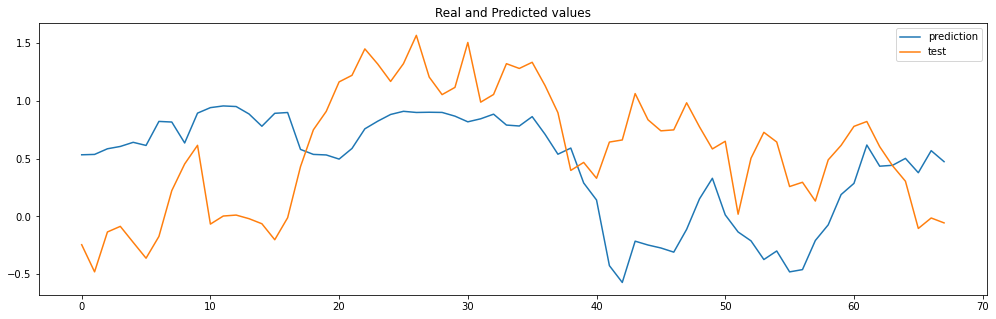

mape    926.526970
mae       0.597595
rmse      0.683244
dtype: float64


In [16]:
rnn_model = basic_RNN()
history_rnn =  rnn_model.fit(**fit_params)
LossPlot(history_rnn)

pred = rnn_model.predict(X_test).flatten()
PredPlot(y_test[:, 0], pred)
brief_stats(y_test[:, 0], pred)

In [17]:
def lstm1():
    model = Sequential()
    model.add(LSTM(12, activation='relu', input_shape=(1,n_input),
                   return_sequences=True
                  ))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    return model

Epoch 1/50
11/11 [==============================] - 0s 21ms/step - loss: 0.8852 - val_loss: 0.4833
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.7843 - val_loss: 0.4651
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6888 - val_loss: 0.4517
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 0.5831 - val_loss: 0.4482
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 0.4801 - val_loss: 0.4561
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.3927 - val_loss: 0.4740
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 0.3323 - val_loss: 0.5005
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2950 - val_loss: 0.5228
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2797 - val_loss: 0.5351
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2727 - val_loss: 0.5411
Epoch 11/50
11/11 

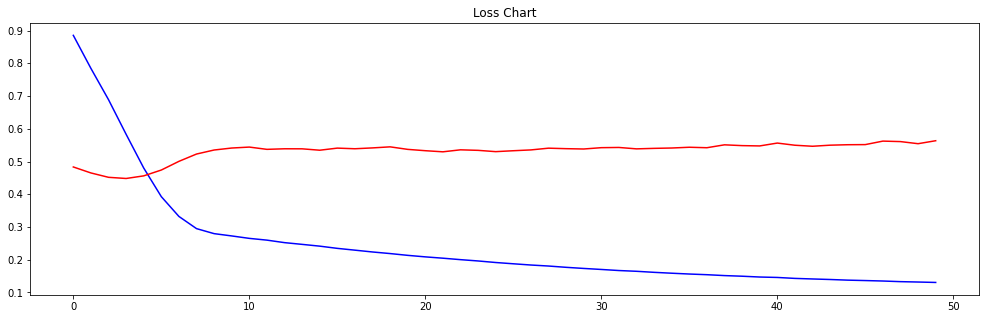

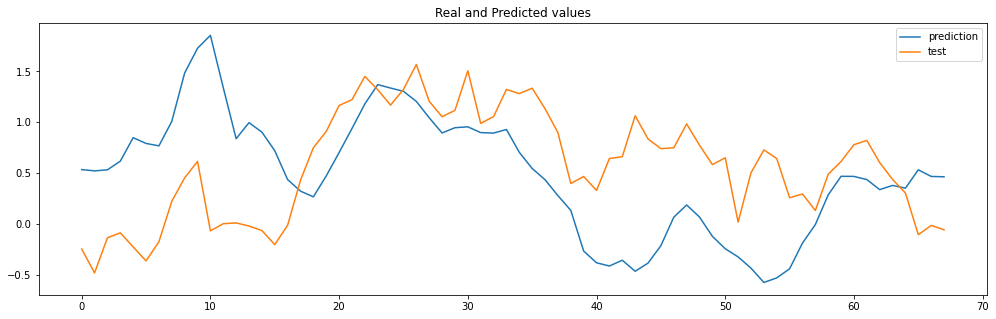

mape    1039.461889
mae        0.633357
rmse       0.750630
dtype: float64


In [18]:
lstm_model = lstm1()
history_lstm =  lstm_model.fit(**fit_params)
LossPlot(history_lstm)

pred = lstm_model.predict(X_test).flatten()
PredPlot(y_test[:, 0], pred)
brief_stats(y_test[:, 0], pred)

In [19]:
def gru1():
    model = Sequential()
    model.add(GRU(12, activation='relu', input_shape=(1,n_input),
                   return_sequences=True
                  ))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    return model

Epoch 1/50
11/11 [==============================] - 0s 23ms/step - loss: 0.8476 - val_loss: 0.5589
Epoch 2/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6548 - val_loss: 0.5268
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.5018 - val_loss: 0.5078
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 0.4066 - val_loss: 0.4956
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 0.3384 - val_loss: 0.4945
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2960 - val_loss: 0.4942
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2715 - val_loss: 0.4996
Epoch 8/50
11/11 [==============================] - 0s 8ms/step - loss: 0.2526 - val_loss: 0.5047
Epoch 9/50
11/11 [==============================] - 0s 8ms/step - loss: 0.2398 - val_loss: 0.5118
Epoch 10/50
11/11 [==============================] - 0s 7ms/step - loss: 0.2299 - val_loss: 0.5158
Epoch 11/50
11/11 

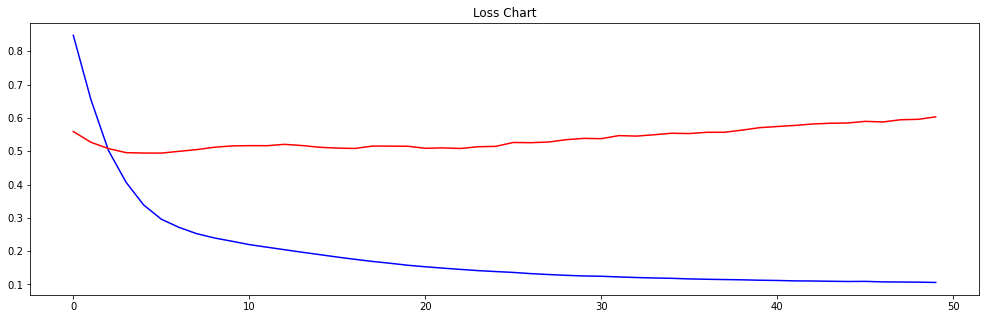

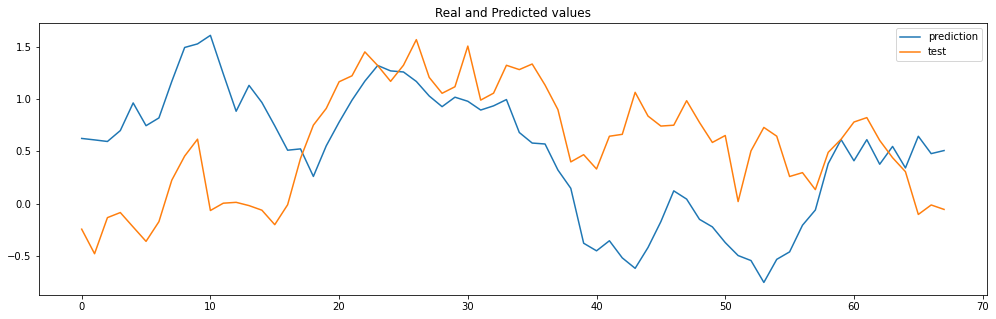

mape    1046.581623
mae        0.649927
rmse       0.776563
dtype: float64


In [20]:
gru_model = gru1()
history_gru = gru_model.fit(**fit_params)
LossPlot(history_gru)

pred = gru_model.predict(X_test).flatten()
PredPlot(y_test[:, 0], pred)
brief_stats(y_test[:, 0], pred)

In [21]:
def gru2():
    model = Sequential()
    model.add(GRU(48, activation='relu', input_shape=(1,n_input),
                   return_sequences=True,
                   recurrent_dropout = 0.1
                  ))
    model.add(GRU(12, activation='relu', input_shape=(1,n_input),
                   return_sequences=True,
                   recurrent_dropout = 0.1
                  ))
    model.add(TimeDistributed(Dense(9)))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    return model

Epoch 1/50
11/11 [==============================] - 1s 59ms/step - loss: 1.0141 - val_loss: 0.6574
Epoch 2/50
11/11 [==============================] - 0s 12ms/step - loss: 0.8697 - val_loss: 0.6644
Epoch 3/50
11/11 [==============================] - 0s 12ms/step - loss: 0.6918 - val_loss: 0.6326
Epoch 4/50
11/11 [==============================] - 0s 12ms/step - loss: 0.4991 - val_loss: 0.5565
Epoch 5/50
11/11 [==============================] - 0s 12ms/step - loss: 0.3453 - val_loss: 0.4693
Epoch 6/50
11/11 [==============================] - 0s 11ms/step - loss: 0.2514 - val_loss: 0.4839
Epoch 7/50
11/11 [==============================] - 0s 11ms/step - loss: 0.2194 - val_loss: 0.5155
Epoch 8/50
11/11 [==============================] - 0s 12ms/step - loss: 0.2038 - val_loss: 0.4916
Epoch 9/50
11/11 [==============================] - 0s 12ms/step - loss: 0.1802 - val_loss: 0.5031
Epoch 10/50
11/11 [==============================] - 0s 11ms/step - loss: 0.1637 - val_loss: 0.5066
Epoch 11/

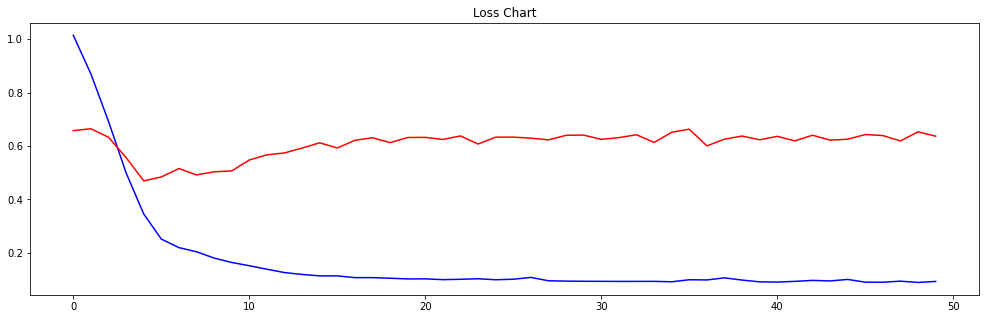

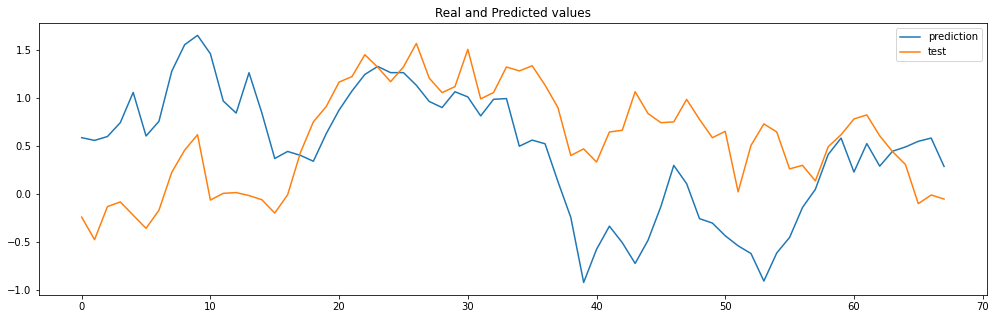

mape    941.020284
mae       0.662935
rmse      0.797810
dtype: float64


In [22]:
gru_model = gru2()
history_gru = gru_model.fit(**fit_params)
LossPlot(history_gru)

pred = gru_model.predict(X_test).flatten()
PredPlot(y_test[:, 0], pred)
brief_stats(y_test[:, 0], pred)

In [23]:
def gru3():
    model = Sequential()
    model.add(GRU(48, input_shape=(1,n_input),
                   return_sequences=True,
                  ))
    model.add(GRU(32,input_shape=(1,n_input),
                   return_sequences=True,
                   dropout = 0.3
                  ))
    model.add(TimeDistributed(Dense(32)))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    return model

Epoch 1/50
11/11 [==============================] - 1s 62ms/step - loss: 0.9057 - val_loss: 0.5394
Epoch 2/50
11/11 [==============================] - 0s 6ms/step - loss: 0.4241 - val_loss: 0.5374
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2400 - val_loss: 0.6465
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.2465 - val_loss: 0.5884
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 0.1990 - val_loss: 0.5417
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 0.1859 - val_loss: 0.5804
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 0.1441 - val_loss: 0.5715
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 0.1586 - val_loss: 0.6099
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 0.1408 - val_loss: 0.6061
Epoch 10/50
11/11 [==============================] - 0s 5ms/step - loss: 0.1343 - val_loss: 0.6093
Epoch 11/50
11/11 

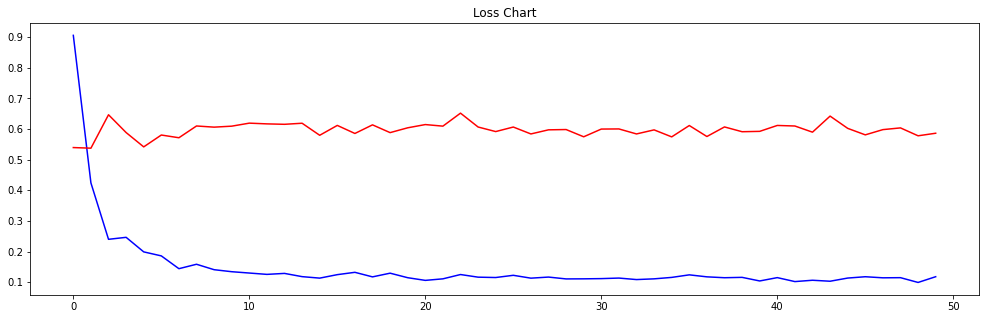

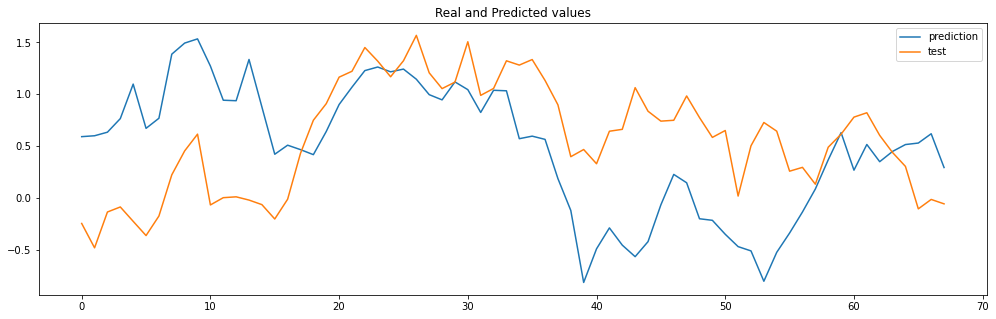

mape    950.674783
mae       0.635984
rmse      0.765633
dtype: float64


In [24]:
gru_model = gru3()
history_gru = gru_model.fit(**fit_params)
LossPlot(history_gru)

pred = gru_model.predict(X_test).flatten()
PredPlot(y_test[:, 0], pred)
brief_stats(y_test[:, 0], pred)